In [1]:
from dash import jupyter_dash
import plotly.express as px

import pandas as pd

jupyter_dash.default_mode="external"

In [5]:
daily_df = pd.read_csv('web_analytics_data_2024-01-01_to_2025-07-31.csv')
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df # = daily_df.set_index('date')

,date,url,marketing_segment,page_visits,unique_visitors,return_visitors
0,2024-01-01,https://example.com/product-page,Direct Traffic,107,84,44
1,2024-01-01,https://example.com/product-page,Display Ads,30,21,1
2,2024-01-01,https://example.com/product-page,Email Marketing,78,49,11
3,2024-01-01,https://example.com/product-page,Organic Search,422,303,0
4,2024-01-01,https://example.com/product-page,Paid Search,190,119,6
...,...,...,...,...,...,...
4619,2025-07-31,https://example.com/product-page,Organic Search,193,133,44
4620,2025-07-31,https://example.com/product-page,Paid Search,131,82,12
4621,2025-07-31,https://example.com/product-page,Referral,40,28,2
4622,2025-07-31,https://example.com/product-page,Social Media,116,87,15


In [20]:
# NOTE: Always create copies when doing transformations
# weekly_df = daily_df.copy().set_index('date').resample('W').agg({
#     'page_visits': 'sum',
#     'unique_visitors': 'sum',
#     'return_visitors': 'sum',
#     'url': 'first',
#     'marketing_segment': lambda x: list(x.unique())
# }).reset_index()

# # Sample at ME - Month End
# monthly_df = daily_df.copy().set_index('date').resample('ME').agg({
#     'page_visits': 'sum',
#     'unique_visitors': 'sum',
#     'return_visitors': 'sum',
#     'url': 'first',
#     'marketing_segment': lambda x: list(x.unique())
# }).reset_index()

# Group by both date period and marketing segment
weekly_df = daily_df.groupby([
    pd.Grouper(key='date', freq='W'),  # Group by month
    'marketing_segment'                  # And by marketing segment
]).agg({
    'page_visits': 'sum',
    'unique_visitors': 'sum',
    'return_visitors': 'sum',
    'url': 'first'
}).reset_index()

# Group by both date period and marketing segment
monthly_df = daily_df.groupby([
    pd.Grouper(key='date', freq='ME'),  # Group by month
    'marketing_segment'                  # And by marketing segment
]).agg({
    'page_visits': 'sum',
    'unique_visitors': 'sum',
    'return_visitors': 'sum',
    'url': 'first'
}).reset_index()



In [21]:
weekly_df.head()

,date,marketing_segment,page_visits,unique_visitors,return_visitors,url
0,2024-01-07,Direct Traffic,839,627,243,https://example.com/product-page
1,2024-01-07,Display Ads,204,133,6,https://example.com/product-page
2,2024-01-07,Email Marketing,531,364,128,https://example.com/product-page
3,2024-01-07,Organic Search,2469,1697,350,https://example.com/product-page
4,2024-01-07,Paid Search,1264,808,69,https://example.com/product-page


In [22]:
df.dtypes

date                 object
url                  object
marketing_segment    object
page_visits           int64
unique_visitors       int64
return_visitors       int64
dtype: object

In [23]:
fig_marketing_segment = px.line(daily_df, x="date", y="page_visits",  facet_row="marketing_segment")

In [24]:
def create_visits_line_graph(df, timeframe='monthly'):
    """
    Function to create a line graph of visits over time with aggregation options
    
    Args:
        df (pandas.DataFrame): DataFrame containing date and visits data
        timeframe (str): Aggregation timeframe - 'daily', 'weekly', or 'monthly'
    
    Returns:
        plotly.graph_objects.Figure: Line graph figure
    """
    # Try to identify date and visits columns automatically
    date_columns = [col for col in df.columns if any(keyword in col.lower() 
                   for keyword in ['date', 'time', 'day', 'month', 'year'])]
    
    visits_columns = [col for col in df.columns if any(keyword in col.lower() 
                     for keyword in ['visit', 'traffic', 'view', 'session', 'user', 'count'])]
    
    # Use the first matching columns, or fallback to first two columns
    date_col = date_columns[0] if date_columns else df.columns[0]
    visits_col = visits_columns[0] if visits_columns else df.columns[1]
    
    # Create a copy to avoid modifying original dataframe
    df_copy = df.copy()
    
    # Ensure date column is datetime
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    
    # Ensure visits column is numeric (convert strings to numbers)
    df_copy[visits_col] = pd.to_numeric(df_copy[visits_col], errors='coerce')
    
    # Sort by date
    df_copy = df_copy.sort_values(date_col)
    
    # Aggregate data based on timeframe
    if timeframe.lower() == 'weekly':
        # Group by week (Monday as start of week)
        df_copy['period'] = df_copy[date_col].dt.to_period('W-MON')
        df_aggregated = df_copy.groupby('period')[visits_col].sum().reset_index()
        df_aggregated['date'] = df_aggregated['period'].dt.start_time
        title_suffix = ' (Weekly Aggregation)'
        xaxis_title = 'Week Starting'
        
    elif timeframe.lower() == 'monthly':
        # Group by month
        df_copy['period'] = df_copy[date_col].dt.to_period('M')
        df_aggregated = df_copy.groupby('period')[visits_col].sum().reset_index()
        df_aggregated['date'] = df_aggregated['period'].dt.start_time
        title_suffix = ' (Monthly Aggregation)'
        xaxis_title = 'Month'
        
    else:  # daily (default)
        # Use daily data as-is, but still group in case there are multiple entries per day
        df_copy['period'] = df_copy[date_col].dt.date
        df_aggregated = df_copy.groupby('period')[visits_col].sum().reset_index()
        df_aggregated['date'] = pd.to_datetime(df_aggregated['period'])
        title_suffix = ' (Daily)'
        xaxis_title = 'Date'
    
    # Create the line graph
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=df_aggregated['date'],
        y=df_aggregated[visits_col],
        mode='lines+markers',
        name='Visits',
        line=dict(color='#1f77b4', width=2),
        marker=dict(size=6, color='#1f77b4'),
        hovertemplate='<b>Date:</b> %{x}<br><b>Visits:</b> %{y:,.0f}<extra></extra>'
    ))
    
    fig.update_layout(
        title={
            'text': f'Website Visits Over Time{title_suffix}',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        xaxis_title=xaxis_title,
        yaxis_title='Number of Visits',
        hovermode='x unified',
        template='plotly_white',
        height=500,
        margin=dict(l=60, r=40, t=80, b=60)
    )
    
    # Format y-axis to show comma-separated numbers
    fig.update_yaxes(tickformat=',')
    
    return fig

In [28]:
import dash
from dash import dcc, html, callback
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import os

# Initialize the Dash app
app = dash.Dash(__name__)



# Load the data directly
df = pd.read_csv('web_analytics_data_2024-01-01_to_2025-07-31.csv')
data_df = df
data_source = 'web_analytics_data_2024-01-01_to_2025-07-31.csv'

# Ensure the visits column is numeric for calculations
visits_col_index = 1
if len(data_df.columns) > 1:
    data_df.iloc[:, visits_col_index] = pd.to_numeric(data_df.iloc[:, visits_col_index], errors='coerce')

# Create the app layout
app.layout = html.Div([
    html.Div([
        html.H1(
            "Website Traffic Dashboard", 
            style={
                'textAlign': 'center',
                'marginBottom': '30px',
                'color': '#2c3e50',
                'fontFamily': 'Arial, sans-serif'
            }
        ),
        
        html.P(
            f"Data source: {data_source}",
            style={
                'textAlign': 'center',
                'color': '#7f8c8d',
                'fontSize': '14px',
                'marginBottom': '20px'
            }
        ),
        
        # Line graph component
        dcc.Graph(
            id='visits-line-graph-daily',
            figure=create_visits_line_graph(data_df, "daily"),
            style={'marginBottom': '20px'}
        ),

        # Line graph component
        dcc.Graph(
            id='visits-line-graph-weekly',
            figure=create_visits_line_graph(data_df, "weekly"),
            style={'marginBottom': '20px'}
        ),

        # Line graph component
        dcc.Graph(
            id='visits-line-graph-monthly',
            figure=create_visits_line_graph(data_df, "monthly"),
            style={'marginBottom': '20px'}
        ),

        # Marketing Segmentes
        dcc.Graph(
            id='visits-line-graph-market-segments',
            figure=px.line(monthly_df, x="date", y="page_visits",  facet_col="marketing_segment", facet_col_wrap=4).for_each_yaxis(lambda yaxis: yaxis.update(matches=None)),
            style={'marginBottom': '20px'}
        ),

        
        
    ], style={
        'maxWidth': '1200px',
        'margin': '0 auto',
        'padding': '20px',
        'fontFamily': 'Arial, sans-serif'
    })
])

# Run the app
if __name__ == '__main__':
    app.run_server(jupyter_mode="tab", port=8058)

Dash app running on http://127.0.0.1:8058/


<IPython.core.display.Javascript object>

In [16]:
daily_df.marketing_segment.value_counts()

marketing_segment
Direct Traffic     578
Display Ads        578
Email Marketing    578
Organic Search     578
Paid Search        578
Referral           578
Social Media       578
Video Ads          578
Name: count, dtype: int64

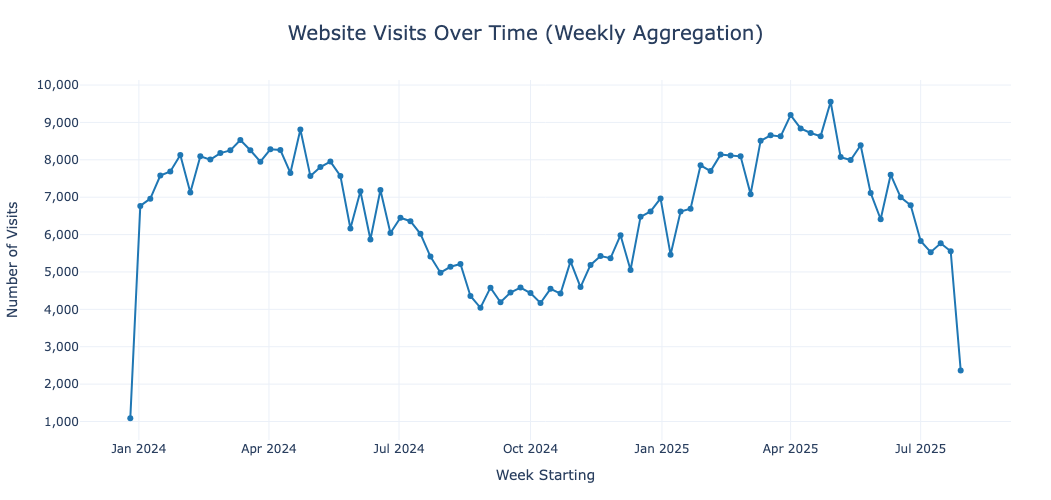

In [31]:
create_visits_line_graph(data_df, "weekly")

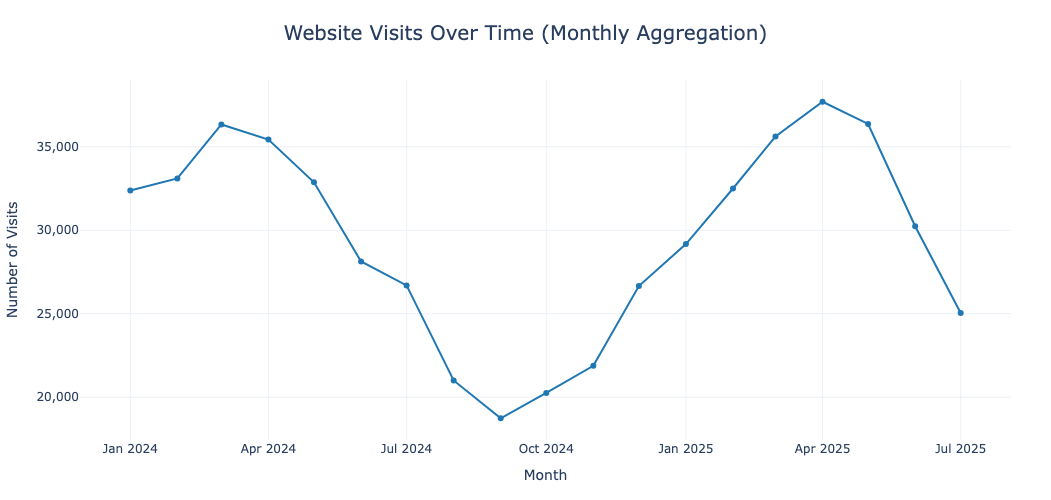

In [30]:
create_visits_line_graph(data_df, "monthly")

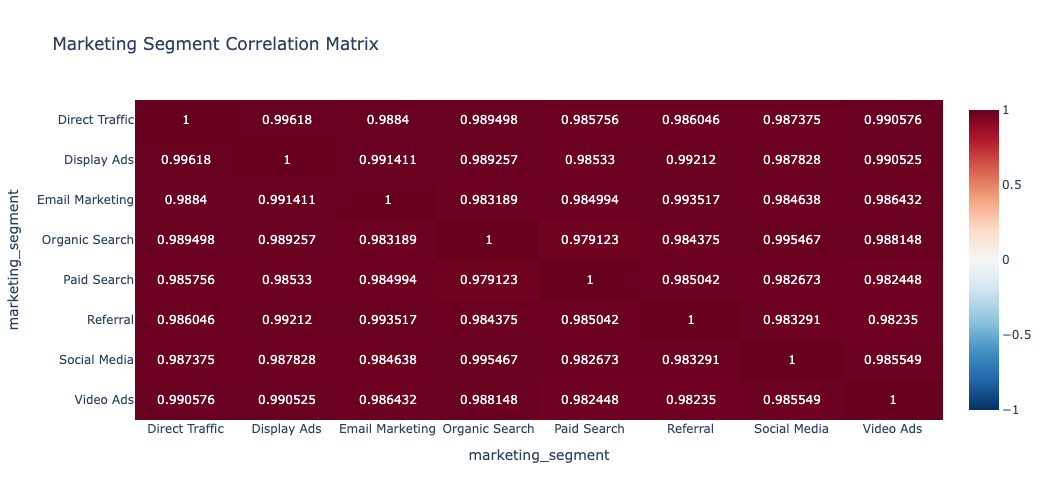

In [34]:
# Pivot data to get segments as columns
pivot_df = monthly_df.pivot(index='date', columns='marketing_segment', values='page_visits')

# Calculate correlation matrix
correlation_matrix = pivot_df.corr()

# Create heatmap
fig = px.imshow(
    correlation_matrix,
    text_auto=True,
    aspect="auto",
    title="Marketing Segment Correlation Matrix",
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1
)

fig.update_layout(
    width=600,
    height=500
)

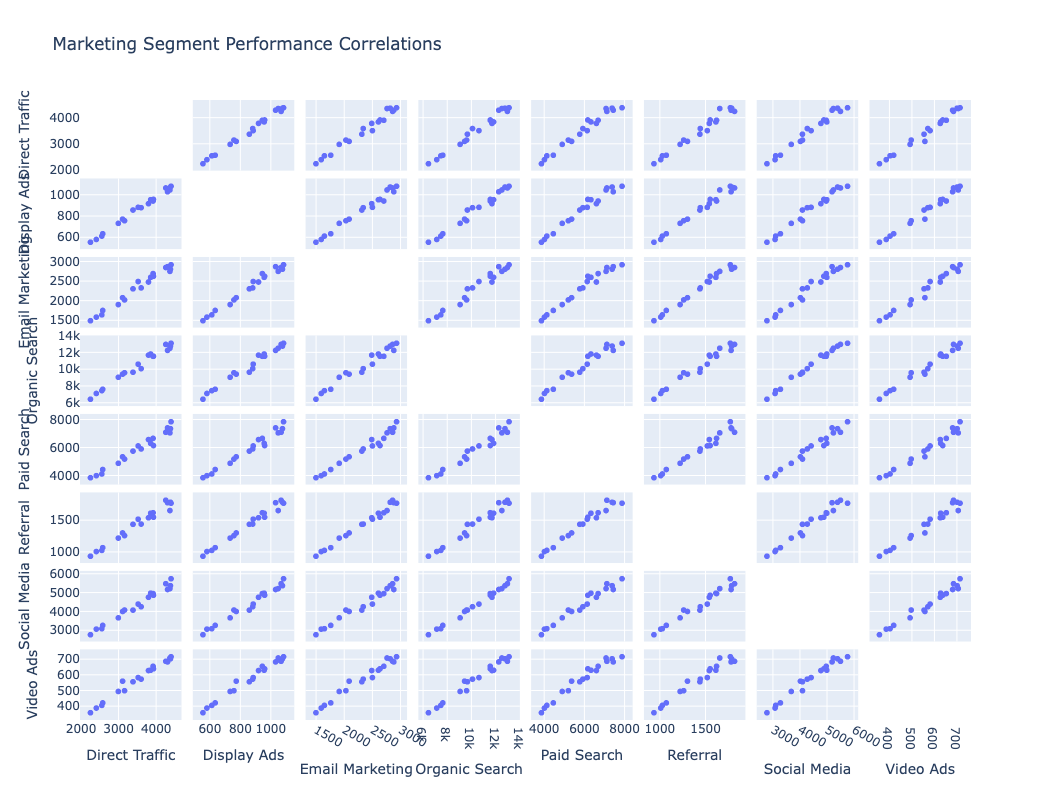

In [35]:
# Create scatter plot matrix
fig = px.scatter_matrix(
    pivot_df,
    title="Marketing Segment Performance Correlations",
    height=800
)

fig.update_traces(diagonal_visible=False)

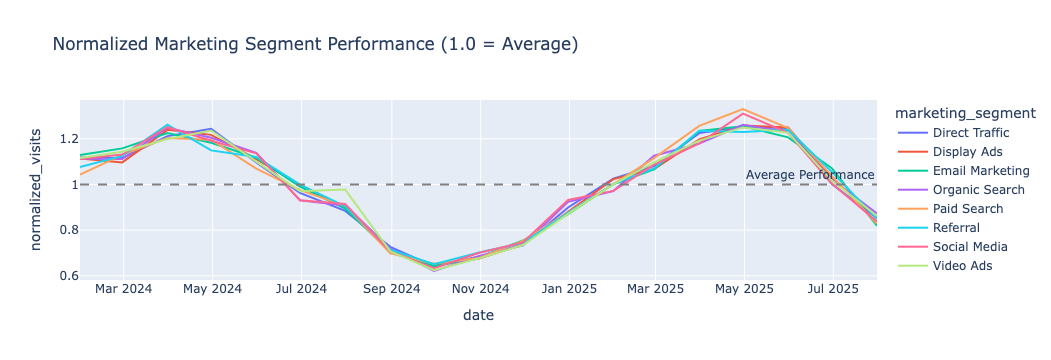

In [36]:
# Normalize each segment to show relative performance
pivot_df_normalized = pivot_df.div(pivot_df.mean()).fillna(0)

# Melt back to long format
normalized_df = pivot_df_normalized.reset_index().melt(
    id_vars='date', 
    var_name='marketing_segment', 
    value_name='normalized_visits'
)

# Create overlay plot
fig = px.line(
    normalized_df,
    x='date',
    y='normalized_visits',
    color='marketing_segment',
    title="Normalized Marketing Segment Performance (1.0 = Average)"
)

fig.add_hline(y=1.0, line_dash="dash", line_color="gray", 
              annotation_text="Average Performance")

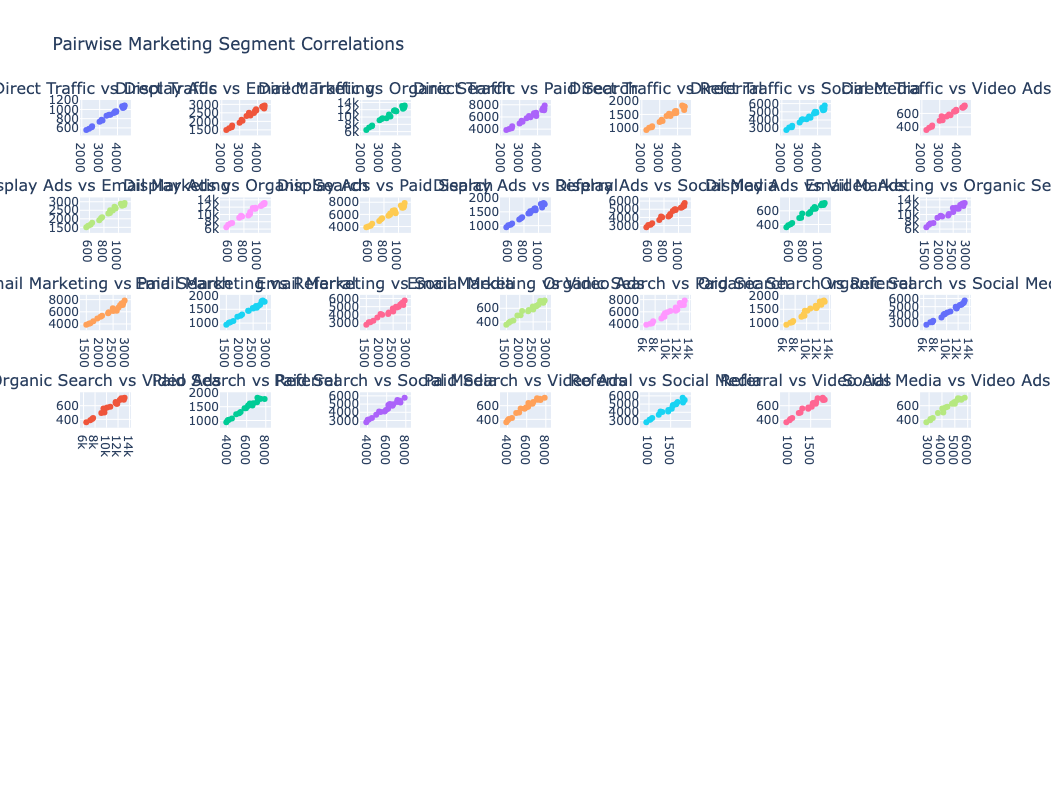

In [37]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats

# Get all unique segments
segments = pivot_df.columns.tolist()
n_segments = len(segments)

# Create subplot grid
fig = make_subplots(
    rows=n_segments-1, 
    cols=n_segments-1,
    subplot_titles=[f"{seg1} vs {seg2}" 
                   for i, seg1 in enumerate(segments[:-1]) 
                   for j, seg2 in enumerate(segments[i+1:], i+1)],
    horizontal_spacing=0.1,
    vertical_spacing=0.1
)

# Add scatter plots for each pair
row, col = 1, 1
for i, seg1 in enumerate(segments[:-1]):
    for j, seg2 in enumerate(segments[i+1:], i+1):
        # Calculate correlation and p-value
        r, p_value = stats.pearsonr(pivot_df[seg1].dropna(), pivot_df[seg2].dropna())
        
        fig.add_trace(
            go.Scatter(
                x=pivot_df[seg1],
                y=pivot_df[seg2],
                mode='markers',
                name=f'r={r:.3f}, p={p_value:.3f}',
                showlegend=False
            ),
            row=row, col=col
        )
        
        # Move to next subplot
        col += 1
        if col > n_segments-1:
            col = 1
            row += 1

fig.update_layout(title="Pairwise Marketing Segment Correlations", height=800)

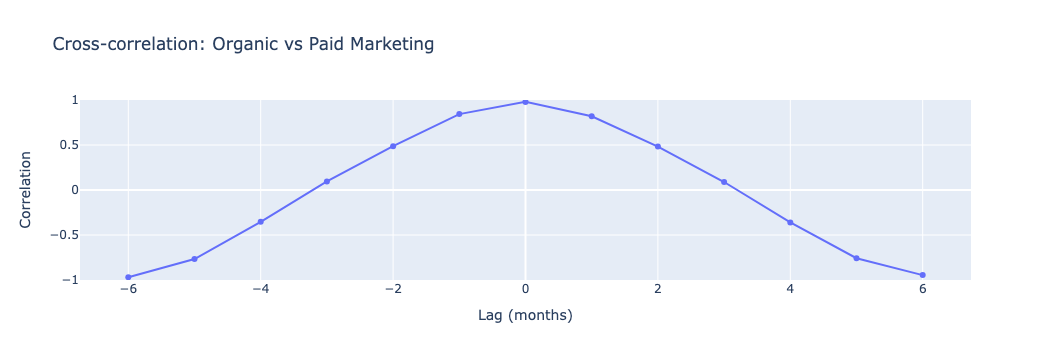

In [42]:
import plotly.graph_objects as go

def cross_correlation(x, y, max_lag=6):
    """Calculate cross-correlation with different lags"""
    correlations = []
    lags = list(range(-max_lag, max_lag + 1))
    
    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(x[-lag:], y[:lag])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[:-lag], y[lag:])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        correlations.append(corr)
    
    return lags, correlations

# Example for two segments
seg1_data = pivot_df['Organic Search'].dropna()
seg2_data = pivot_df['Paid Search'].dropna()

lags, correlations = cross_correlation(seg1_data, seg2_data)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=lags,
    y=correlations,
    mode='lines+markers',
    name='Cross-correlation'
))

fig.update_layout(
    title="Cross-correlation: Organic vs Paid Marketing",
    xaxis_title="Lag (months)",
    yaxis_title="Correlation",
    yaxis=dict(range=[-1, 1])
)

In [41]:
pivot_df.columns

Index(['Direct Traffic', 'Display Ads', 'Email Marketing', 'Organic Search',
       'Paid Search', 'Referral', 'Social Media', 'Video Ads'],
      dtype='object', name='marketing_segment')